Using TensorFlow version: 2.19.0

===== Adam 预训练 =====
Epoch 0, loss=4.6453e+01, L1=3.4676e+01, L2=1.1777e+01
Epoch 500, loss=5.3049e-02, L1=1.8450e-02, L2=3.4599e-02
Epoch 1000, loss=3.0563e-02, L1=9.3978e-03, L2=2.1165e-02
Epoch 1500, loss=2.2199e-02, L1=8.2875e-03, L2=1.3912e-02
Epoch 2000, loss=1.6818e-02, L1=7.0677e-03, L2=9.7502e-03

===== L-BFGS-B 精调 =====
Optimizer: L-BFGS-B (Provided by SciPy)
Initializing ...
Iter: 10   L1 = 0.00707   L2 = 0.008957
Iter: 20   L1 = 0.005848   L2 = 0.007203
Iter: 30   L1 = 0.006108   L2 = 0.004848
Iter: 40   L1 = 0.006118   L2 = 0.00327
Iter: 50   L1 = 0.004542   L2 = 0.003168
Iter: 60   L1 = 0.00382   L2 = 0.003343
Iter: 70   L1 = 0.003308   L2 = 0.003173
Iter: 80   L1 = 0.003055   L2 = 0.002983
Iter: 90   L1 = 0.002988   L2 = 0.002493
Iter: 100   L1 = 0.003218   L2 = 0.003878
Iter: 110   L1 = 0.002619   L2 = 0.002047
Iter: 120   L1 = 0.0023   L2 = 0.001931
Iter: 130   L1 = 0.002104   L2 = 0.001617
Iter: 140   L1 = 0.00184   L2 = 0.001593
Iter

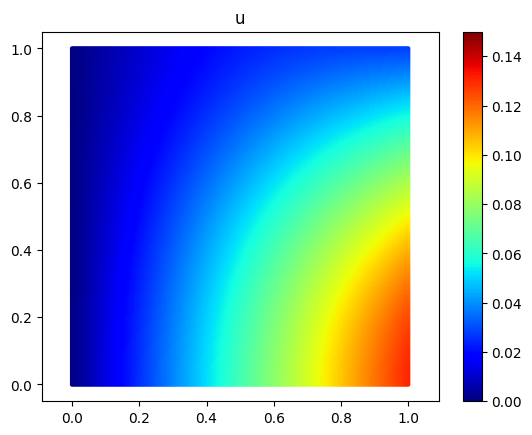

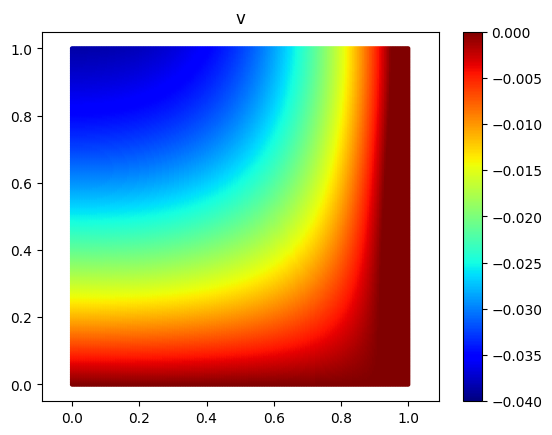

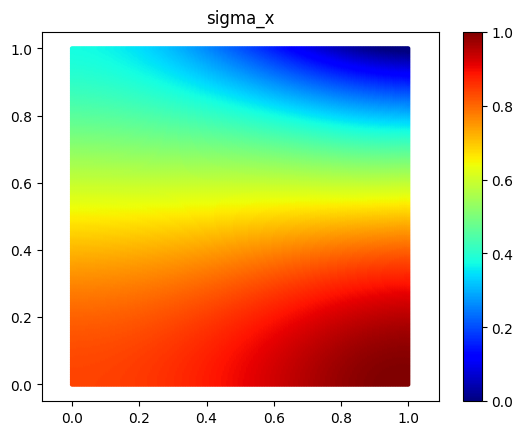

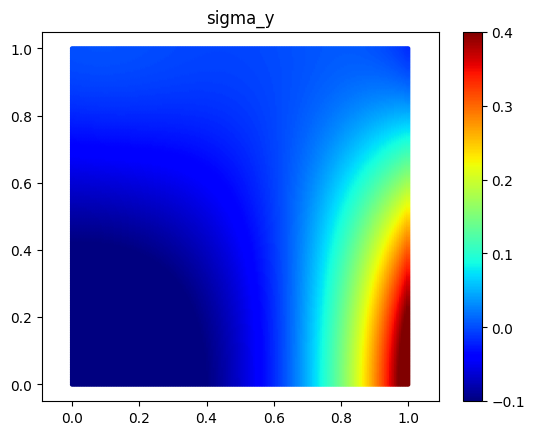

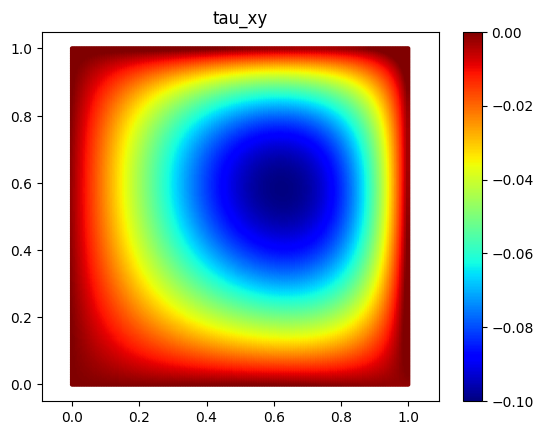

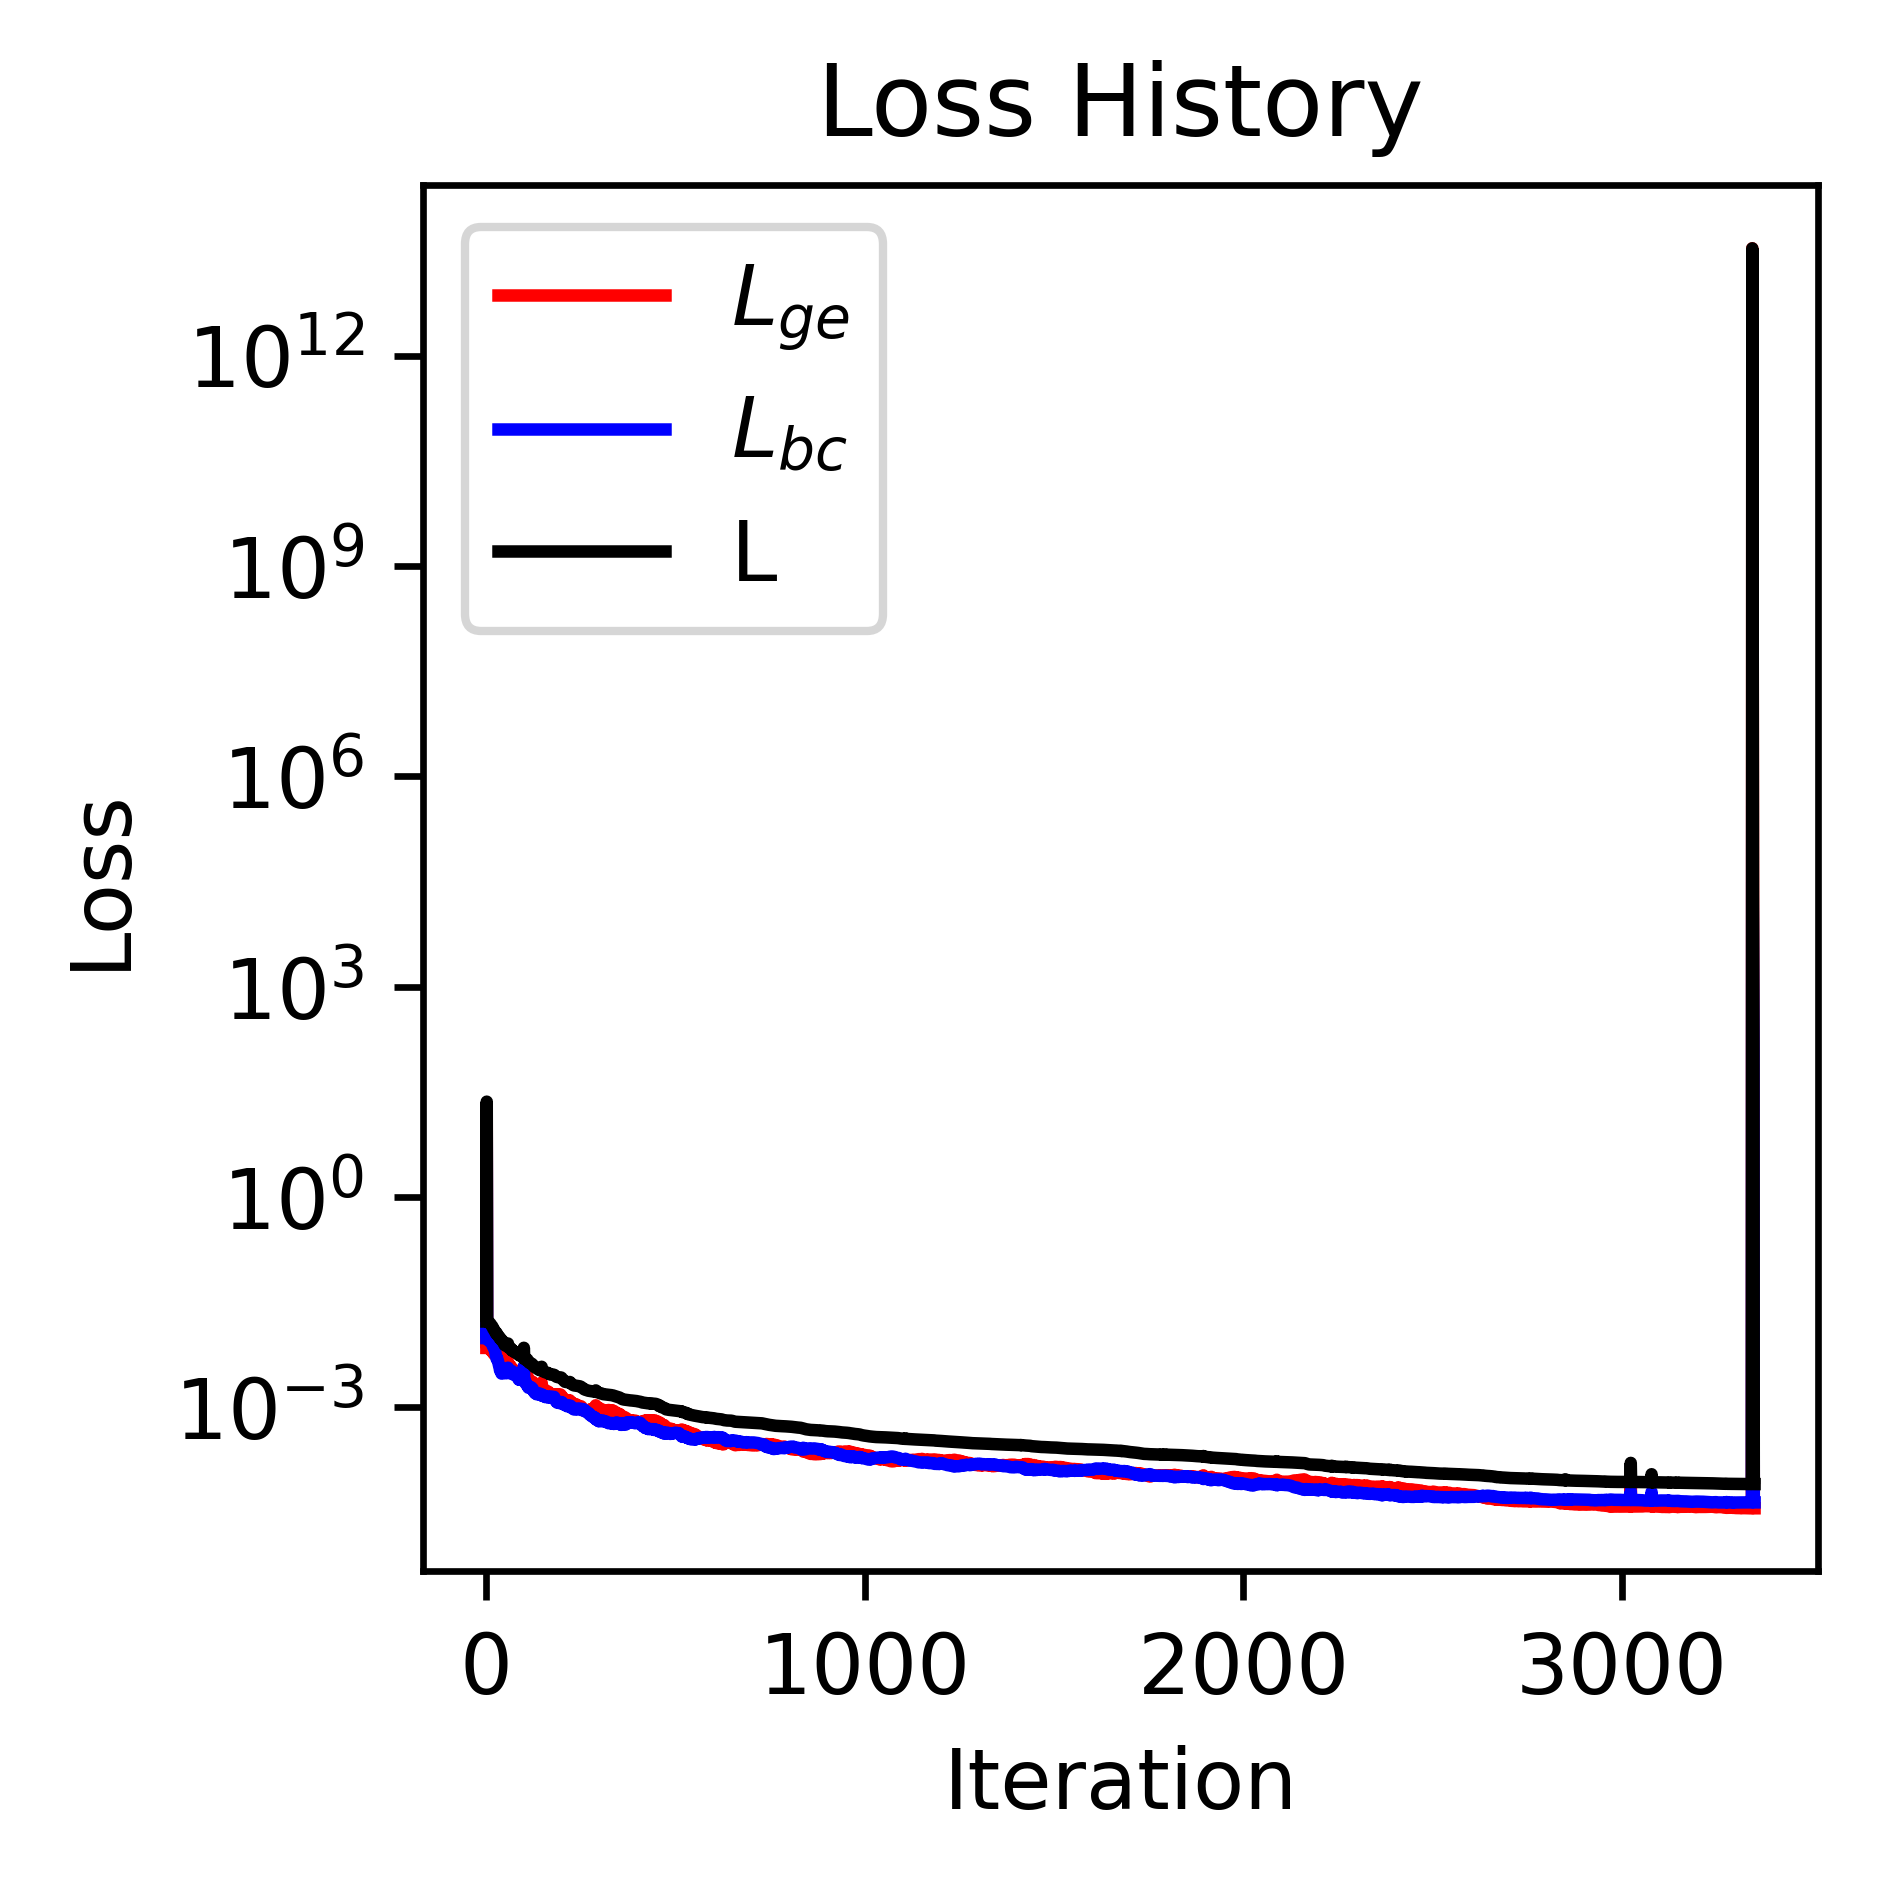

In [1]:
import tensorflow as tf
import os
import numpy as np
import math
import time
import scipy.optimize
import matplotlib.pyplot as plt

# 关闭 TF 冗余日志
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Using TensorFlow version:", tf.__version__)

# ============================= 数据生成 =============================
ns_u = 51
ns_l = 51
ns = ns_u * ns_l
dx = 1. / (ns_u - 1)

xy = np.zeros((ns, 2), dtype=np.float32)
for i in range(ns_u):
    for j in range(ns_l):
        xy[i * ns_l + j, 0] = i * dx
        xy[i * ns_l + j, 1] = j * dx

xy_u = np.hstack([np.linspace(0, 1, ns_u).reshape(ns_u, 1).astype(np.float32), np.ones((ns_u, 1), dtype=np.float32)])
xy_b = np.hstack([np.linspace(0, 1, ns_u).reshape(ns_u, 1).astype(np.float32), np.zeros((ns_u, 1), dtype=np.float32)])
xy_l = np.hstack([np.zeros((ns_l, 1), dtype=np.float32), np.linspace(0, 1, ns_l).reshape(ns_l, 1).astype(np.float32)])
xy_r = np.hstack([np.ones((ns_l, 1), dtype=np.float32), np.linspace(0, 1, ns_l).reshape(ns_l, 1).astype(np.float32)])

x_train = [xy, xy_u, xy_b, xy_l, xy_r]

# 材料参数
E = 7.0
mu = 0.3

# 边界条件
s_u_x = np.zeros((ns_u, 1), dtype=np.float32)
s_u_y = np.zeros((ns_u, 1), dtype=np.float32)
s_b_x = np.zeros((ns_u, 1), dtype=np.float32)
s_b_y = np.zeros((ns_u, 1), dtype=np.float32)
s_l_x = np.zeros((ns_l, 1), dtype=np.float32)
s_l_y = np.zeros((ns_l, 1), dtype=np.float32)
s_r_x = np.cos(xy_r[..., 1, np.newaxis] / 2 * math.pi)
s_r_y = np.zeros((ns_l, 1), dtype=np.float32)
y_train = [s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y]

# ============================= FNN 定义 =============================
def FNN(n_input, n_output, layers, acti_fun='tanh', k_init='LecunNormal'):
    x = tf.keras.layers.Input(shape=(n_input,))
    temp = x
    for l in layers:
        temp = tf.keras.layers.Dense(l, activation=acti_fun, kernel_initializer=k_init)(temp)
    y = tf.keras.layers.Dense(n_output, kernel_initializer=k_init)(temp)
    return tf.keras.models.Model(inputs=x, outputs=y)

n_input, n_output = 2, 1
layer = [np.array([20, 20, 20]), np.array([20, 20, 20])]
NN_info = [n_input, n_output, layer]

net_u = FNN(NN_info[0], NN_info[1], NN_info[2][0])
net_v = FNN(NN_info[0], NN_info[1], NN_info[2][1])

# ============================= 自动微分 =============================
class Dif_x(tf.keras.layers.Layer):
    def __init__(self, fnn, **kwargs):
        self.fnn = fnn
        super().__init__(**kwargs)

    @tf.function
    def call(self, xy):
        x, y = xy[..., 0:1], xy[..., 1:2]
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                temp = self.fnn(tf.concat([x, y], axis=-1))
                U = temp * x
            U_x = g.gradient(U, x)
            U_y = g.gradient(U, y)
        U_xx = gg.gradient(U_x, x)
        U_xy = gg.gradient(U_x, y)
        U_yy = gg.gradient(U_y, y)
        return U_x, U_y, U_xx, U_xy, U_yy

class Dif_y(tf.keras.layers.Layer):
    def __init__(self, fnn, **kwargs):
        self.fnn = fnn
        super().__init__(**kwargs)

    @tf.function
    def call(self, xy):
        x, y = xy[..., 0:1], xy[..., 1:2]
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                temp = self.fnn(tf.concat([x, y], axis=-1))
                V = temp * y
            V_x = g.gradient(V, x)
            V_y = g.gradient(V, y)
        V_xx = gg.gradient(V_x, x)
        V_xy = gg.gradient(V_x, y)
        V_yy = gg.gradient(V_y, y)
        return V_x, V_y, V_xx, V_xy, V_yy

# ============================= 材料本构关系 =============================
def Material(U_x, U_y, V_x, V_y, U_xx, U_xy, U_yy, V_xx, V_xy, V_yy, E, mu, p):
    if p == 'plain_strain':
        la = E * mu / (1 + mu) / (1 - 2 * mu)
        nu = E / (1 + mu) / 2
    elif p == 'plain_stress':
        la = E * mu / (1 + mu) / (1 - mu)
        nu = E / (1 + mu) / 2
    e1 = U_x
    e2 = V_y
    e12 = 0.5 * (U_y + V_x)
    s1 = (2 * nu + la) * e1 + la * e2
    s2 = (2 * nu + la) * e2 + la * e1
    s12 = 2 * nu * e12
    Gex = (2 * nu + la) * U_xx + nu * U_yy + (nu + la) * V_xy
    Gey = (nu + la) * U_xy + (2 * nu + la) * V_yy + nu * V_xx
    return e1, e2, e12, s1, s2, s12, Gex, Gey

# ============================= PINN 构建 =============================
def PINN(net_u, net_v, E, mu):
    xy = tf.keras.layers.Input(shape=(2,))
    xy_u = tf.keras.layers.Input(shape=(2,))
    xy_b = tf.keras.layers.Input(shape=(2,))
    xy_l = tf.keras.layers.Input(shape=(2,))
    xy_r = tf.keras.layers.Input(shape=(2,))

    dif_x = Dif_x(net_u)
    dif_y = Dif_y(net_v)

    U_x, U_y, U_xx, U_xy, U_yy = dif_x(xy)
    V_x, V_y, V_xx, V_xy, V_yy = dif_y(xy)

    U_u_x, U_u_y, U_u_xx, U_u_xy, U_u_yy = dif_x(xy_u)
    V_u_x, V_u_y, V_u_xx, V_u_xy, V_u_yy = dif_y(xy_u)

    U_b_x, U_b_y, U_b_xx, U_b_xy, U_b_yy = dif_x(xy_b)
    V_b_x, V_b_y, V_b_xx, V_b_xy, V_b_yy = dif_y(xy_b)

    U_l_x, U_l_y, U_l_xx, U_l_xy, U_l_yy = dif_x(xy_l)
    V_l_x, V_l_y, V_l_xx, V_l_xy, V_l_yy = dif_y(xy_l)

    U_r_x, U_r_y, U_r_xx, U_r_xy, U_r_yy = dif_x(xy_r)
    V_r_x, V_r_y, V_r_xx, V_r_xy, V_r_yy = dif_y(xy_r)

    p = 'plain_stress'
    _, _, _, _, _, _, Gex, Gey = Material(U_x, U_y, V_x, V_y, U_xx, U_xy, U_yy, V_xx, V_xy, V_yy, E, mu, p)
    _, _, _, _, s_u_y, s_u_x, _, _ = Material(U_u_x, U_u_y, V_u_x, V_u_y, U_u_xx, U_u_xy, U_u_yy, V_u_xx, V_u_xy, V_u_yy, E, mu, p)
    _, _, _, _, s_b_y, s_b_x, _, _ = Material(U_b_x, U_b_y, V_b_x, V_b_y, U_b_xx, U_b_xy, U_b_yy, V_b_xx, V_b_xy, V_b_yy, E, mu, p)
    _, _, _, s_l_x, _, s_l_y, _, _ = Material(U_l_x, U_l_y, V_l_x, V_l_y, U_l_xx, U_l_xy, U_l_yy, V_l_xx, V_l_xy, V_l_yy, E, mu, p)
    _, _, _, s_r_x, _, s_r_y, _, _ = Material(U_r_x, U_r_y, V_r_x, V_r_y, U_r_xx, U_r_xy, U_r_yy, V_r_xx, V_r_xy, V_r_yy, E, mu, p)

    return tf.keras.Model(inputs=[xy, xy_u, xy_b, xy_l, xy_r],
                          outputs=[Gex, Gey, s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y])

# ============================= 损失函数 =============================
def Collocation_Loss(y_p, y):
    l1 = tf.reduce_mean(tf.square(y_p[0])) + tf.reduce_mean(tf.square(y_p[1]))
    l2 = (tf.reduce_mean(tf.square(y_p[2] - y[0])) +
          tf.reduce_mean(tf.square(y_p[3] - y[1])) +
          tf.reduce_mean(tf.square(y_p[4] - y[2])) +
          tf.reduce_mean(tf.square(y_p[7] - y[5])) +
          tf.reduce_mean(tf.square(y_p[8] - y[6])) +
          tf.reduce_mean(tf.square(y_p[9] - y[7])))
    return l1 + l2, l1, l2

# ============================= L-BFGS-B 优化器 =============================
class L_BFGS_B:
    def __init__(self, pinn, x_train, y_train, dx, factr=10, pgtol=1e-10, m=50, maxls=50, maxfun=40000):
        self.pinn = pinn
        self.x_train = [tf.constant(x, dtype=tf.float32) for x in x_train]
        self.y_train = [tf.constant(y, dtype=tf.float32) for y in y_train]
        self.dx = dx
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxfun = maxfun
        self.iter = 0
        self.his_loss_ge = []
        self.his_loss_bc = []

    def pi_loss(self, weights):
        self.set_weights(weights)
        loss, grads, l1, l2 = self.loss_grad(self.x_train, self.y_train)
        self.iter += 1
        if self.iter % 10 == 0:
            print(f"Iter: {self.iter}   L1 = {l1.numpy():.4g}   L2 = {l2.numpy():.4g}")
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')
        self.his_loss_ge.append(l1.numpy())
        self.his_loss_bc.append(l2.numpy())
        return loss, grads

    @tf.function
    def loss_grad(self, x, y):
        with tf.GradientTape() as g:
            y_p = self.pinn(x)
            loss, l1, l2 = Collocation_Loss(y_p, y)
        grads = g.gradient(loss, self.pinn.trainable_variables)
        return loss, grads, l1, l2

    def set_weights(self, flat_weights):
        shapes = [w.shape for w in self.pinn.get_weights()]
        split_ids = np.cumsum([np.prod(shape) for shape in [0] + shapes])
        weights = [flat_weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]
        self.pinn.set_weights(weights)

    def fit(self):
        ini_w = np.concatenate([w.flatten() for w in self.pinn.get_weights()])
        print("Optimizer: L-BFGS-B (Provided by SciPy)")
        print("Initializing ...")
        result = scipy.optimize.fmin_l_bfgs_b(func=self.pi_loss, x0=ini_w,
                    factr=self.factr, pgtol=self.pgtol, m=self.m,
                    maxls=self.maxls, maxfun=self.maxfun)
        return result, [np.array(self.his_loss_ge), np.array(self.his_loss_bc)]

# ============================= Adam + L-BFGS-B 联合训练 =============================
pinn = PINN(net_u, net_v, E, mu)

# Adam 预训练
adam_epochs = 2000
adam_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=adam_lr)

@tf.function
def train_step(x_train, y_train):
    with tf.GradientTape() as tape:
        y_pred = pinn(x_train)
        loss, l1, l2 = Collocation_Loss(y_pred, y_train)
    grads = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    return loss, l1, l2

print("\n===== Adam 预训练 =====")
for epoch in range(adam_epochs + 1):
    loss, l1, l2 = train_step(
        [tf.constant(x, dtype=tf.float32) for x in x_train],
        [tf.constant(y, dtype=tf.float32) for y in y_train]
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, loss={loss.numpy():.4e}, L1={l1.numpy():.4e}, L2={l2.numpy():.4e}")

# L-BFGS-B 精调
print("\n===== L-BFGS-B 精调 =====")
l_bfgs_b = L_BFGS_B(pinn, x_train, y_train, dx)
time_start = time.time()
hist, his_loss = l_bfgs_b.fit()
time_end = time.time()

print(f"\n训练总时间: {time_end - time_start:.2f} 秒")
print(f"最终 Loss = {hist[1]}, 迭代次数 = {hist[2]['funcalls']}")

# ============================= 后处理可视化 =============================
xy_plot = np.zeros((201*201, 2), dtype=np.float32)
k = 0
for i in range(201):
    for j in range(201):
        xy_plot[k, 0] = i / 200
        xy_plot[k, 1] = j / 200
        k += 1

u = net_u(xy_plot).numpy() * xy_plot[..., 0:1]
v = net_v(xy_plot).numpy() * xy_plot[..., 1:2]
temp = pinn([xy_plot for _ in range(5)])
temp = [t.numpy() for t in temp]
s11, s22, s12 = temp[6], temp[3], temp[2]

for name, data, vmin, vmax in [
    ('u', u, 0, 0.15),
    ('v', v, -4e-2, 0),
    ('sigma_x', s11, 0, 1),
    ('sigma_y', s22, -0.1, 0.4),
    ('tau_xy', s12, -0.1, 0)
]:
    plt.figure()
    plt.scatter(xy_plot[:, 0], xy_plot[:, 1], s=5, c=data, cmap='jet', vmin=vmin, vmax=vmax)
    plt.axis('equal')
    plt.colorbar()
    plt.title(name)
    plt.savefig(f"{name}.tiff", dpi=600)

plt.figure(figsize=(3, 3), dpi=600)
plt.plot(his_loss[0], 'r')
plt.plot(his_loss[1], 'b')
plt.plot(his_loss[0] + his_loss[1], 'k')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend(['$L_{ge}$', '$L_{bc}$', 'L'])
plt.savefig('hist_loss.tiff', dpi=600, bbox_inches='tight')
plt.show()